## Installation of libraries

In [ ]:
!pip install roboflow tensorflow numpy matplotlib

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.5/75.5 kB 3.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 158.3/158.3 kB 7.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 178.7/178.7 kB 8.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 8.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.1/49.1 MB 17.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.5/54.5 kB 8.8 MB/s eta 0:00:00
  Attempting uninstall: opencv-python-headless
    Found existing installation: opencv-python-headless 4.9.0.80
    Uninstalling opencv-python-headless-4.9.0.80:
      Successfully uninstalled opencv-python-headless-4.9.0.80
  Attempting uninstall: idna
    Found existing installation: idna 3.7
    Uninstalling idna-3.7:
      Successfully uninstalled idna-3.7
  Attempting uninstall: cycler
    Found existing installation: cycler 0.12.1
    Uninstalling cycler-0.12.1:
      Successfully uninstalled cycler-0.12

## Import Libraries

In [ ]:
from roboflow import Roboflow
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from PIL import Image

## Import Data

In [ ]:
# Download dataset using Roboflow
from roboflow import Roboflow
rf = Roboflow(api_key="RpzjqD048vaNzxiav0PF")
project = rf.workspace("planes-zmdv1").project("commerc-yjcqe")
version = project.version(2)
dataset = version.download("yolov5")

loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to Commerc-2 in yolov5pytorch:: 100%|██████████| 1902/1902 [00:01<00:00, 1199.83it/s]


## VAE Code

Epoch 1, Loss: 7753.5093
Epoch 2, Loss: 7753.0972
Epoch 3, Loss: 7752.5342
Epoch 4, Loss: 7752.9331
Epoch 5, Loss: 7752.7886
Epoch 6, Loss: 7752.3047
Epoch 7, Loss: 7752.5601
Epoch 8, Loss: 7752.8867
Epoch 9, Loss: 7751.9844
Epoch 10, Loss: 7753.0127
Epoch 11, Loss: 7752.0229
Epoch 12, Loss: 7752.5098
Epoch 13, Loss: 7751.9722
Epoch 14, Loss: 7752.0874
Epoch 15, Loss: 7752.4888
Epoch 16, Loss: 7752.2798
Epoch 17, Loss: 7752.3706
Epoch 18, Loss: 7752.3706
Epoch 19, Loss: 7752.1475
Epoch 20, Loss: 7751.9761
Epoch 21, Loss: 7751.9409
Epoch 22, Loss: 7752.1025
Epoch 23, Loss: 7752.1548
Epoch 24, Loss: 7752.1367
Epoch 25, Loss: 7751.9849
Epoch 26, Loss: 7751.0156
Epoch 27, Loss: 7751.7939
Epoch 28, Loss: 7752.3525
Epoch 29, Loss: 7751.8130
Epoch 30, Loss: 7751.5093
Epoch 31, Loss: 7751.7104
Epoch 32, Loss: 7752.1025
Epoch 33, Loss: 7751.5020
Epoch 34, Loss: 7751.7061
Epoch 35, Loss: 7751.0249
Epoch 36, Loss: 7751.8936
Epoch 37, Loss: 7751.2202
Epoch 38, Loss: 7750.8149
Epoch 39, Loss: 7751.

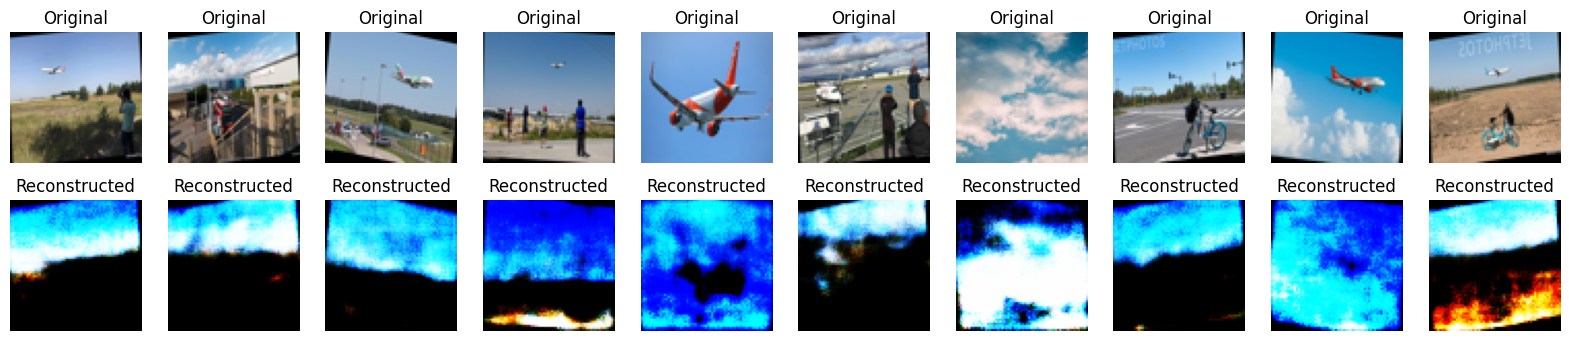

In [ ]:
def load_images(image_folder, image_size=(64, 64)):
    images = []
    for filename in os.listdir(image_folder):
        if filename.endswith(".jpg") or filename.endswith(".png"):
            img_path = os.path.join(image_folder, filename)
            img = Image.open(img_path).resize(image_size)
            img = np.array(img) / 255.0  # Normalize to [0, 1]
            img = img.astype(np.float32)  # Convert to float32
            images.append(img)
    return np.array(images)

image_folder = os.path.join(dataset.location, 'train/images')
images = load_images(image_folder)

# Split dataset into training and validation sets
train_images, val_images = train_test_split(images, test_size=0.2, random_state=42)

# Define the VAE architecture
latent_dim = 16

# Encoder
class Encoder(tf.keras.Model):
    def __init__(self, latent_dim):
        super(Encoder, self).__init__()
        self.conv1 = layers.Conv2D(32, 3, activation='relu', strides=2, padding='same', kernel_regularizer=tf.keras.regularizers.l2(0.001))
        self.conv2 = layers.Conv2D(64, 3, activation='relu', strides=2, padding='same', kernel_regularizer=tf.keras.regularizers.l2(0.001))
        self.conv3 = layers.Conv2D(128, 3, activation='relu', strides=2, padding='same', kernel_regularizer=tf.keras.regularizers.l2(0.001))
        self.conv4 = layers.Conv2D(256, 3, activation='relu', strides=2, padding='same', kernel_regularizer=tf.keras.regularizers.l2(0.001))
        self.flatten = layers.Flatten()
        self.fc1 = layers.Dense(512, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001))
        self.fc2 = layers.Dense(latent_dim + latent_dim)  # Mean and log variance

    def call(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = self.flatten(x)
        x = self.fc1(x)
        x = self.fc2(x)
        mean, logvar = tf.split(x, num_or_size_splits=2, axis=1)
        logvar = tf.clip_by_value(logvar, -5.0, 5.0)  # Clip log variance to prevent very large values
        return mean, logvar

# Define Decoder
class Decoder(tf.keras.Model):
    def __init__(self):
        super(Decoder, self).__init__()
        self.fc1 = layers.Dense(8*8*256, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001))  # Adjusted to match encoder output
        self.reshape = layers.Reshape((8, 8, 256))
        self.deconv1 = layers.Conv2DTranspose(128, 3, activation='relu', strides=2, padding='same', kernel_regularizer=tf.keras.regularizers.l2(0.001))
        self.deconv2 = layers.Conv2DTranspose(64, 3, activation='relu', strides=2, padding='same', kernel_regularizer=tf.keras.regularizers.l2(0.001))
        self.deconv3 = layers.Conv2DTranspose(32, 3, activation='relu', strides=2, padding='same', kernel_regularizer=tf.keras.regularizers.l2(0.001))
        self.output_layer = layers.Conv2DTranspose(3, 3, activation='sigmoid', padding='same')  # Output to match original image size

    def call(self, x):
        x = self.fc1(x)
        x = self.reshape(x)
        x = self.deconv1(x)
        x = self.deconv2(x)
        x = self.deconv3(x)
        x = self.output_layer(x)
        return x

# VAE
class VAE(tf.keras.Model):
    def __init__(self, encoder, decoder, latent_dim):
        super(VAE, self).__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.latent_dim = latent_dim

    def reparameterize(self, mean, logvar):
        eps = tf.random.normal(shape=mean.shape)
        return eps * tf.exp(logvar * 0.5) + mean

    def call(self, x):
        mean, logvar = self.encoder(x)
        z = self.reparameterize(mean, logvar)
        reconstructed = self.decoder(z)
        return reconstructed, mean, logvar

# Loss function
def log_normal_pdf(sample, mean, logvar, raxis=1):
    log2pi = tf.math.log(2. * np.pi)
    return tf.reduce_sum(
        -.5 * ((sample - mean) ** 2. * tf.exp(-logvar) + logvar + log2pi),
        axis=raxis)

def compute_loss(model, x):
    reconstructed, mean, logvar = model(x)
    cross_ent = tf.nn.sigmoid_cross_entropy_with_logits(logits=reconstructed, labels=x)
    logpx_z = -tf.reduce_sum(cross_ent, axis=[1, 2, 3])
    logpz = log_normal_pdf(tf.zeros_like(mean), tf.zeros_like(mean), tf.zeros_like(logvar))
    logqz_x = log_normal_pdf(mean, mean, logvar)
    return -tf.reduce_mean(logpx_z + logpz - logqz_x)

# Train the VAE
optimizer = tf.keras.optimizers.Adam(1e-8)  # Lowered learning rate
epochs = 200
batch_size = 64


#initial_learning_rate = 1e-2
#lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
#    initial_learning_rate,
#    decay_steps=100000,
#    decay_rate=0.96,
#    staircase=True)

#optimizer = tf.keras.mixed_precision.LossScaleOptimizer(tf.keras.optimizers.Adam(learning_rate=lr_schedule), dynamic=True)


#@tf.function
#def train_step(model, x, optimizer):
#    with tf.GradientTape() as tape:
#        loss = compute_loss(model, x)
#        scaled_loss = optimizer.get_scaled_loss(loss)
#    scaled_grad = tape.gradient(scaled_loss,model.trainable_variables)
#    grads = optimizer.get_unscaled_gradients(scaled_grad)
#    optimizer.apply_gradients(zip(grads, model.trainable_variables))

@tf.function
def train_step(model, x, optimizer):
    with tf.GradientTape() as tape:
        loss = compute_loss(model, x)
    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    return loss

encoder = Encoder(latent_dim)
decoder = Decoder()
vae = VAE(encoder, decoder, latent_dim)
_ = vae(tf.zeros((1, 64, 64, 3)))
vae.load_weights('/content/vae_weights.h5')

for epoch in range(1, epochs + 1):
    for i in range(0, len(train_images), batch_size):
        batch = train_images[i:i + batch_size]
        if np.any(np.isnan(batch)):  # Check for NaNs in input data
            print("NaN found in input data!")
            continue
        loss= train_step(vae, batch, optimizer)
    val_loss = compute_loss(vae, val_images)
    print(f'Epoch {epoch}, Loss: {val_loss:.4f}')
    if np.isnan(val_loss):
        print("NaN encountered during training. Stopping.")
        break

# Save the trained model
vae.save_weights('vae_weights.h5')

# Example usage: reconstruct some images
def plot_reconstruction(model, images, n=10):
    plt.figure(figsize=(20, 4))
    for i in range(n):
        ax = plt.subplot(2, n, i + 1)
        plt.imshow(images[i])
        plt.title("Original")
        plt.axis("off")

        ax = plt.subplot(2, n, i + 1 + n)
        reconstructed, _, _ = model(images[i:i + 1])
        plt.imshow(reconstructed[0])
        plt.title("Reconstructed")
        plt.axis("off")
    plt.show()

plot_reconstruction(vae, val_images)
